### Import libraries and data

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.manifold import Isomap
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from scipy.stats import ranksums

In [21]:
data = pd.read_csv("data.csv")
data.head()

,Class,Mouse,Measurement,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,...,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior
0,c-CS-m,309,1,0.151122,0.212885,0.824638,0.612119,0.630482,0.327006,0.448666,...,0.426816,0.133930,0.336299,0.087715,0.102890,0.084580,0.705738,Control,Memantine,C/S
1,c-CS-m,309,2,0.155750,0.188226,0.776455,0.601070,0.585247,0.311887,0.429899,...,0.429952,0.110434,0.365208,0.080692,0.115874,0.093977,0.749771,Control,Memantine,C/S
2,c-CS-m,309,3,0.153459,0.205696,0.793572,0.558911,0.575910,0.306369,0.441381,...,0.448652,0.121560,0.353621,0.080465,0.109050,0.082162,0.868229,Control,Memantine,C/S
3,c-CS-m,309,4,0.125169,0.157688,0.637326,0.468152,0.480646,0.335530,0.444307,...,0.392700,0.151031,0.265619,0.126763,0.164241,0.144543,0.721879,Control,Memantine,C/S
4,c-CS-m,309,5,0.122146,0.157838,0.637787,0.426467,0.441977,0.314976,0.433100,...,0.410187,0.147711,0.350381,0.096959,0.136298,0.149281,0.812053,Control,Memantine,C/S


### Subset Data and convert to arrays

In [22]:
controlX = data.loc[data.loc[:,"Genotype"] == "Control",:].iloc[:,3:80].values
controlY = data.loc[data.loc[:,"Genotype"] == "Control",:].iloc[:,0]
trisomicX = data.loc[data.loc[:,"Genotype"] == "Ts65Dn",:].iloc[:,3:80].values
trisomicY = data.loc[data.loc[:,"Genotype"] == "Ts65Dn",:].iloc[:,0]

### Clustering and Visualization
Step 1 for ISOMAP is to build a weighted adjacency matrix. In order to do this, I need to choose a threshold euclidean distance (all points within this threshold distance of each other are connected to each other, and all points fruther away than this are not connected). 

Text(0.5, 0, '1')

<Figure size 432x288 with 0 Axes>

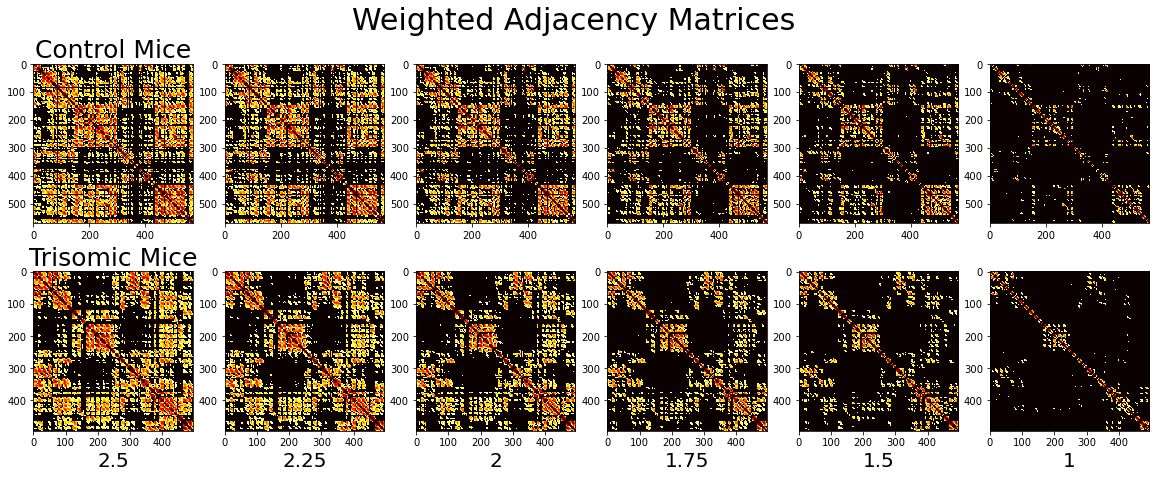

In [23]:
# set threshold candidates
epsilon = [2.5, 2.25, 2, 1.75, 1.5, 1]

storeControl = []
storeTrisomic = []
for e in epsilon:
    # calculate pairwise distances and store in a matrix
    euclideanDistsControl = pairwise_distances(controlX) * pairwise_distances(controlX) 
    euclideanDistsTrisomic = pairwise_distances(trisomicX) * pairwise_distances(trisomicX)
    # convert to adjacency matrix
    edgesControl = np.where(euclideanDistsControl <= e, 1, 0) # adjacency matrix, boolean
    edgesTrisomic = np.where(euclideanDistsTrisomic <= e, 1, 0)
    AControl = np.multiply(euclideanDistsControl, edgesControl) # adjacency matrix, weighted by distances
    ATrisomic = np.multiply(euclideanDistsTrisomic, edgesTrisomic)
    storeControl.append(AControl)
    storeTrisomic.append(ATrisomic)

plt.figure()
f, arr = plt.subplots(2,6, figsize=(20, 7))
f.suptitle("Weighted Adjacency Matrices", fontsize = 30)

for i in range(6):
    arr[0,i].imshow(storeControl[i], cmap='hot', interpolation='nearest')
    arr[1,i].imshow(storeTrisomic[i], cmap='hot', interpolation='nearest')
arr[0,0].set_title("Control Mice", {'fontsize':25})
arr[1,0].set_title("Trisomic Mice", {'fontsize':25})
arr[1,0].set_xlabel("2.5", {'fontsize':20})
arr[1,1].set_xlabel("2.25", {'fontsize':20})
arr[1,2].set_xlabel("2", {'fontsize':20})
arr[1,3].set_xlabel("1.75", {'fontsize':20})
arr[1,4].set_xlabel("1.5", {'fontsize':20})
arr[1,5].set_xlabel("1", {'fontsize':20})

Based on this, a threshold of 1.75 seems to be a good choice.

Since the purpose of ISOMAP here is to aid visualization, it's not immediately clear whether ISOMAP should be implemented prior to clustering.

Now, I will do three things:
1. Compress data using ISOMAP and plot. Color points according to true class labels.
2. Cluster compressed data and plot. Color points according to predicted class labels.
3. Cluster data in original dimensions, then compress using ISOMAP, and plot. Color points according to predicted class labels.

Whichever of (2) and (3) matches more with (1) will be the process I follow.

Text(0.5, 1.0, 'Trisomic Mice')

<Figure size 432x288 with 0 Axes>

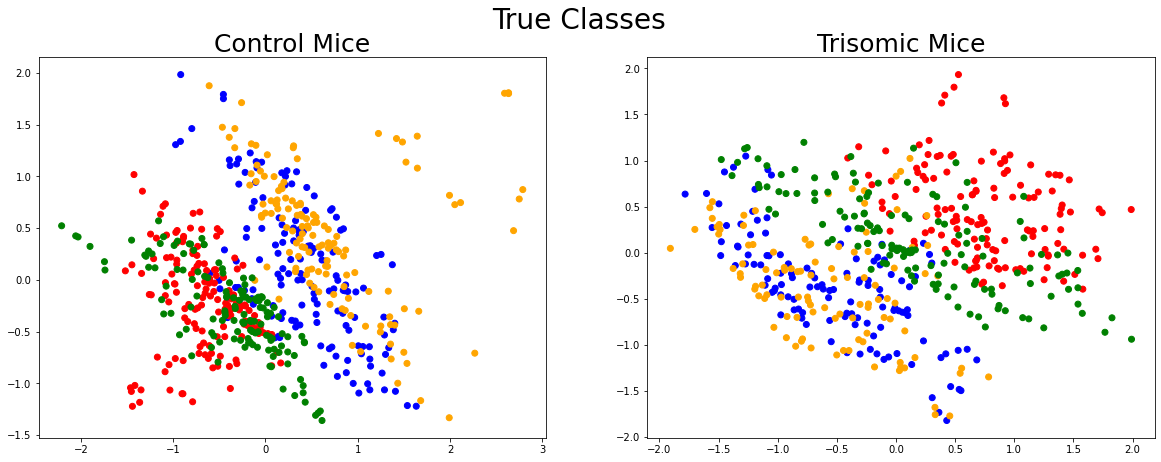

In [170]:
# Compress data using ISOMAP and plot
plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
f.suptitle("True Classes", fontsize = 28)


isoControl = Isomap(n_neighbors = None,
                    radius=1.75, 
                    n_components = 2).fit_transform(controlX)
isoTrisomic = Isomap(n_neighbors = None,
                    radius=1.75, 
                    n_components = 2).fit_transform(trisomicX)

colsControl = {'c-CS-m': 'blue', 'c-SC-m':'red', 'c-CS-s':'orange', 'c-SC-s':'green'}
colsTrisomic = {'t-CS-m': 'blue', 't-SC-m':'red', 't-CS-s':'orange', 't-SC-s':'green'}


ax1.scatter(isoControl[:,0], isoControl[:,1], c= controlY.map(colsControl))
ax2.scatter(isoTrisomic[:,0], isoTrisomic[:,1], c= trisomicY.map(colsTrisomic))
ax1.set_title("Control Mice", {'fontsize':25})
ax2.set_title("Trisomic Mice", {'fontsize':25})

Just based on this we can already see a pretty good separation between control mice who learned (yellow and blue) and control mice who did not learn (red and green). The presence/absence of memantine doesn't seem to have made a difference.

For trisomic mice also, mice who were subjected to the context shock treatment (mice who were supposed to learn) form a mixed cluster (blue and orange), while mice who did not receive the learning treatment are separated based on memantine treatment.

Text(0.5, 1.0, 'Trisomic Mice')

<Figure size 640x480 with 0 Axes>

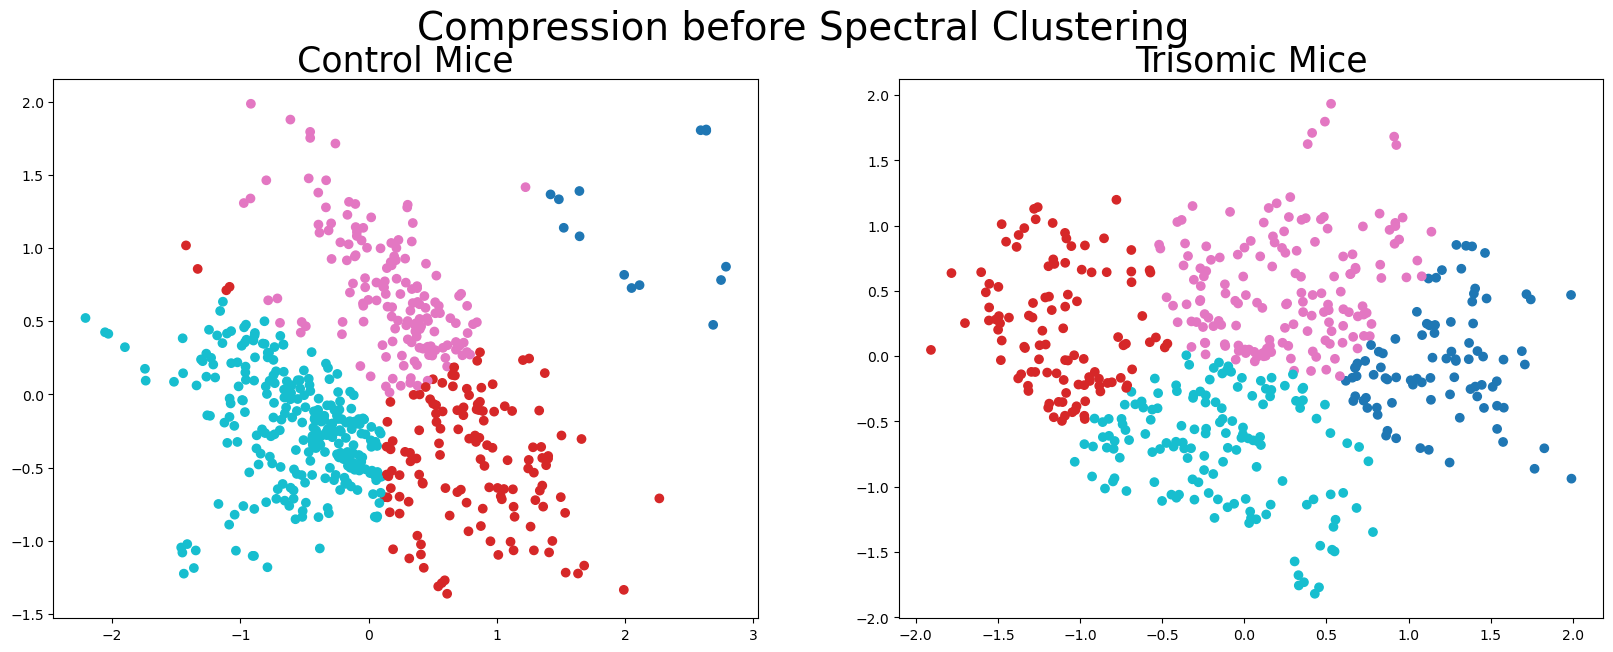

In [180]:
# 2 Cluster compressed data

plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
f.suptitle("Compression before Spectral Clustering", fontsize = 28)

clustersControl = SpectralClustering(n_clusters = 4,
                              assign_labels = "cluster_qr").fit_predict(isoControl)
clustersTrisomic = SpectralClustering(n_clusters = 4,
                              assign_labels = "cluster_qr").fit_predict(isoTrisomic)

ax1.scatter(isoControl[:,0], isoControl[:,1], c= clustersControl, cmap=plt.get_cmap("tab10"))
ax2.scatter(isoTrisomic[:,0], isoTrisomic[:,1], c= clustersTrisomic, cmap=plt.get_cmap("tab10"))
ax1.set_title("Control Mice", {'fontsize':25})
ax2.set_title("Trisomic Mice", {'fontsize':25})

Text(0.5, 1.0, 'Trisomic Mice')

<Figure size 640x480 with 0 Axes>

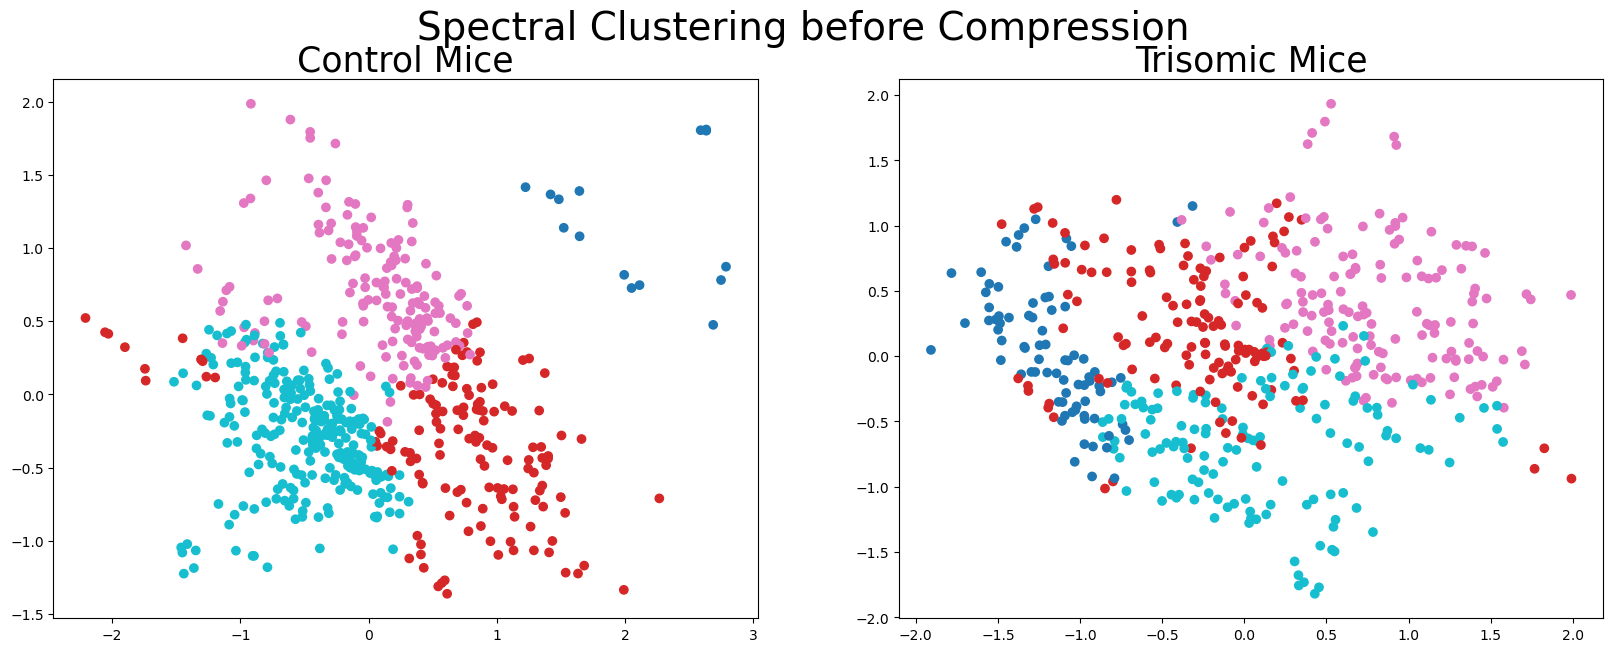

In [179]:
# 3 Clustering in original vector space

plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
f.suptitle("Spectral Clustering before Compression", fontsize = 28)

clustersControl3 = SpectralClustering(n_clusters = 4,
                              assign_labels = "cluster_qr").fit_predict(controlX)
clustersTrisomic3 = SpectralClustering(n_clusters = 4,
                              assign_labels = "cluster_qr").fit_predict(trisomicX)

ax1.scatter(isoControl[:,0], isoControl[:,1], c= clustersControl3, cmap=plt.get_cmap("tab10"))
ax2.scatter(isoTrisomic[:,0], isoTrisomic[:,1], c= clustersTrisomic3, cmap=plt.get_cmap("tab10"))
ax1.set_title("Control Mice", {'fontsize':25})
ax2.set_title("Trisomic Mice", {'fontsize':25})

Neither of the two methods is clustering data the way it is in reality. However, clustering the data prior to visualizing it seems to repect the boundary between mice that learned and mice that did not learn, a little more than clustering prior to compressing.

Still, I'm not satisfied. I will try the DBSCAN algorithm instead.

[-1  0  1  2  3  4  5  6  7]
[-1  0  1  2  3  4  5  6  7]


<Figure size 640x480 with 0 Axes>

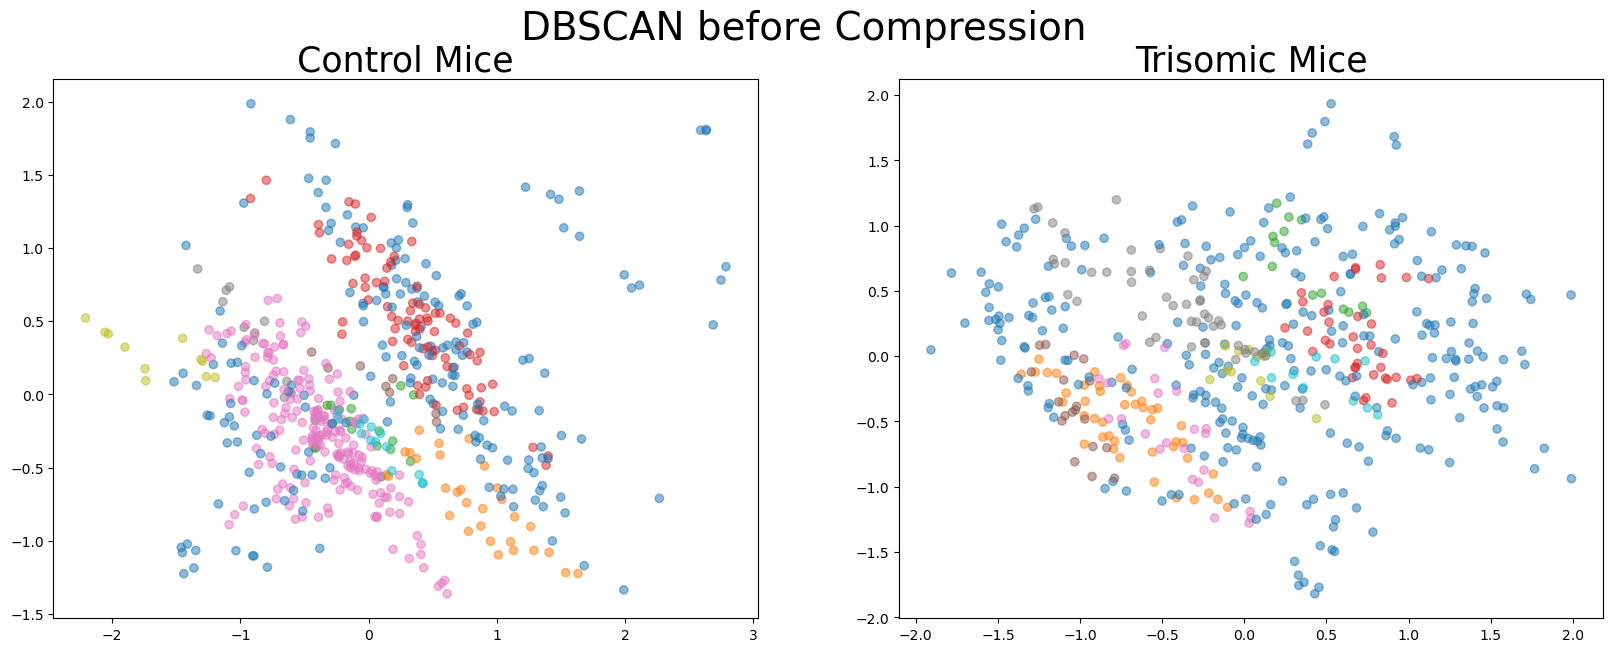

In [187]:
plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
f.suptitle("DBSCAN before Compression", fontsize = 28)

DBControl1 = DBSCAN(eps = 0.752, min_samples = 11).fit(controlX)
DBTrisomic1 = DBSCAN(eps = 0.752, min_samples = 13).fit(trisomicX)

ax1.scatter(isoControl[:,0], isoControl[:,1], c= DBControl1.labels_, cmap=plt.get_cmap("tab10"), alpha = 0.5)
ax2.scatter(isoTrisomic[:,0], isoTrisomic[:,1], c= DBTrisomic1.labels_, cmap=plt.get_cmap("tab10"), alpha = 0.5)
ax1.set_title("Control Mice", {'fontsize':25})
ax2.set_title("Trisomic Mice", {'fontsize':25})

print(np.unique(DBControl1.labels_))
print(np.unique(DBTrisomic1.labels_))

[-1  0]
[0]


<Figure size 640x480 with 0 Axes>

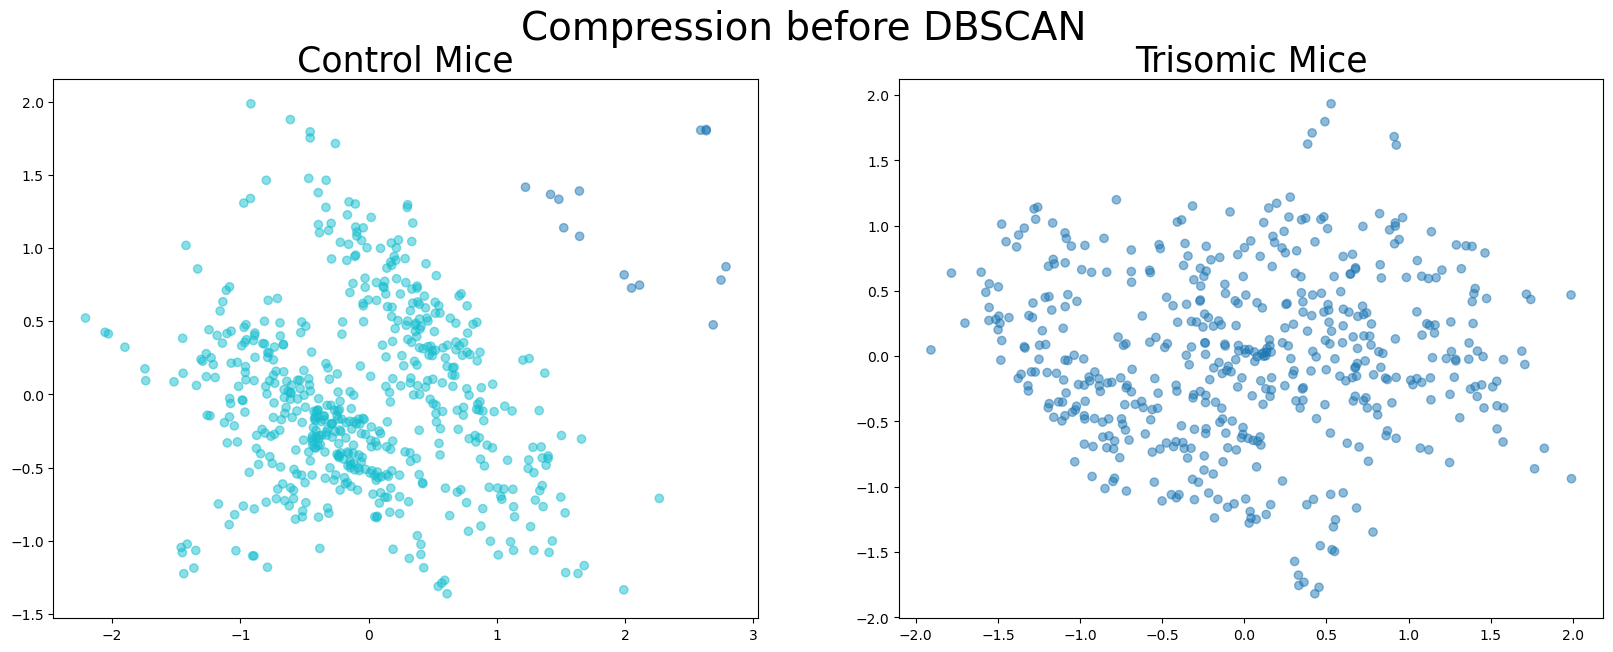

In [195]:
plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
f.suptitle("Compression before DBSCAN", fontsize = 28)

DBControl2 = DBSCAN(eps = 0.752, min_samples = 11).fit(isoControl)
DBTrisomic2 = DBSCAN(eps = 0.752, min_samples = 13).fit(isoTrisomic)

ax1.scatter(isoControl[:,0], isoControl[:,1], c= DBControl2.labels_, cmap=plt.get_cmap("tab10"), alpha = 0.5)
ax2.scatter(isoTrisomic[:,0], isoTrisomic[:,1], c= DBTrisomic2.labels_, cmap=plt.get_cmap("tab10"), alpha = 0.5)
ax1.set_title("Control Mice", {'fontsize':25})
ax2.set_title("Trisomic Mice", {'fontsize':25})

print(np.unique(DBControl2.labels_))
print(np.unique(DBTrisomic2.labels_))

Now, I will use clusters from DBSCAN before compression to assign cluster labels to datapoints. In the interest of keepiing all data together, join the DBSCAN clusters to the dataframe subsets corresponding to control and trisomic mice.

In [337]:
controlData = data.loc[data.loc[:,"Genotype"] == "Control",:]
controlClustersDBSCAN = pd.Series(DBControl1.labels_)
clusteredControls = pd.concat([controlData, controlClustersDBSCAN], axis = 1).rename(columns = {0:'DBCluster'})

trisomicData = data.loc[data.loc[:,"Genotype"] == "Ts65Dn",:].reset_index(drop = True)
trisomicClustersDBSCAN = pd.Series(DBTrisomic1.labels_)
clusteredTrisomics = pd.concat([trisomicData, trisomicClustersDBSCAN], axis = 1).rename(columns = {0:'DBCluster'})

### Clustering Quality Evaluation and Modifications
Before we can evaluate whether applying DBSCAN to the original data can identify proteins whose expression levels discriminate between mouse classes, let's take a look at the composition of the clusters that we have so far.

In [338]:
mcsControl = pd.DataFrame(clusteredControls.groupby("DBCluster")["Class"].value_counts())
mcsTrisomic = pd.DataFrame(clusteredTrisomics.groupby("DBCluster")["Class"].value_counts())
display(mcsControl)
display(mcsTrisomic)

Class
DBCluster Class        
-1        c-CS-s     92
          c-CS-m     53
          c-SC-m     31
          c-SC-s     21
 0        c-CS-m     30
 1        c-CS-m     16
 2        c-CS-s     43
          c-CS-m     42
 3        c-CS-m      9
 4        c-SC-m    108
          c-SC-s     89
 5        c-SC-m     11
 6        c-SC-s     11
 7        c-SC-s     14

Class
DBCluster Class        
-1        t-SC-m     84
          t-CS-m     72
          t-CS-s     66
          t-SC-s     63
 0        t-CS-m     44
 1        t-SC-m     14
 2        t-SC-m     37
 3        t-CS-s     15
          t-CS-m      4
 4        t-CS-s     24
 5        t-SC-s     49
 6        t-SC-s     12
 7        t-SC-s     11

Most mouse classes occur in multiple clusters. We can combine some clusters, and ignore points in mixed clusters and points assigned as noise.

For the control mice, we can modify DBClusters as follows
1. clusters 0, 1 and 3 are grouped to form the c-CS-m group
2. cluster 5 alone forms the c-SC-m group
3. clusters 6 and 7 are grouped to form the c-SC-s group
4. from cluster 2 we only keep data corresponding to c-CS-s. This is because the proportions of the two types of mice in the cluster are not that different from each other, and c-CS-s doesn’t appear in any other class, indicating that datapoints corresponding to this class occurs close together in the original 77-dimensional vector space. 

For the trisomic mice, we can modify DBClusters as follows:
1. cluster 0 alone forms the t-CS-m group
2. cluster 4 alone forms the t-CS-s group
3. clusters 1 and 2 are combined to form the t-SC-m group
4. clusters 5, 6 and 7 are grouped to form the t-SC-s group

In [368]:
valuesControl = ["Noise", "c-CS-m", "c-CS-m", "c-CS-s","c-CS-m", "Noise", "c-SC-m", "c-SC-s", "c-SC-s"]
valuesTrisomic = ["Noise", "t-CS-m", "t-SC-m", "t-SC-m", "Noise", "t-CS-s", "t-SC-s", "t-SC-s", "t-SC-s"]
for i in zip([clusteredControls, clusteredTrisomics], [valuesControl, valuesTrisomic]):
    conditions_i = [i[0]["DBCluster"] == -1,
                      i[0]["DBCluster"] == 0, i[0]["DBCluster"] == 1,
                      i[0]["DBCluster"] == 2, i[0]["DBCluster"] == 3,
                      i[0]["DBCluster"] == 4, i[0]["DBCluster"] == 5,
                      i[0]["DBCluster"] == 6, i[0]["DBCluster"] == 7]
    values_i = i[1]
    i[0]["DBSuper"] = np.select(conditions_i, values_i)

Now, let's plot the new clusters I created and check if they agree with the true data labels.

<Figure size 640x480 with 0 Axes>

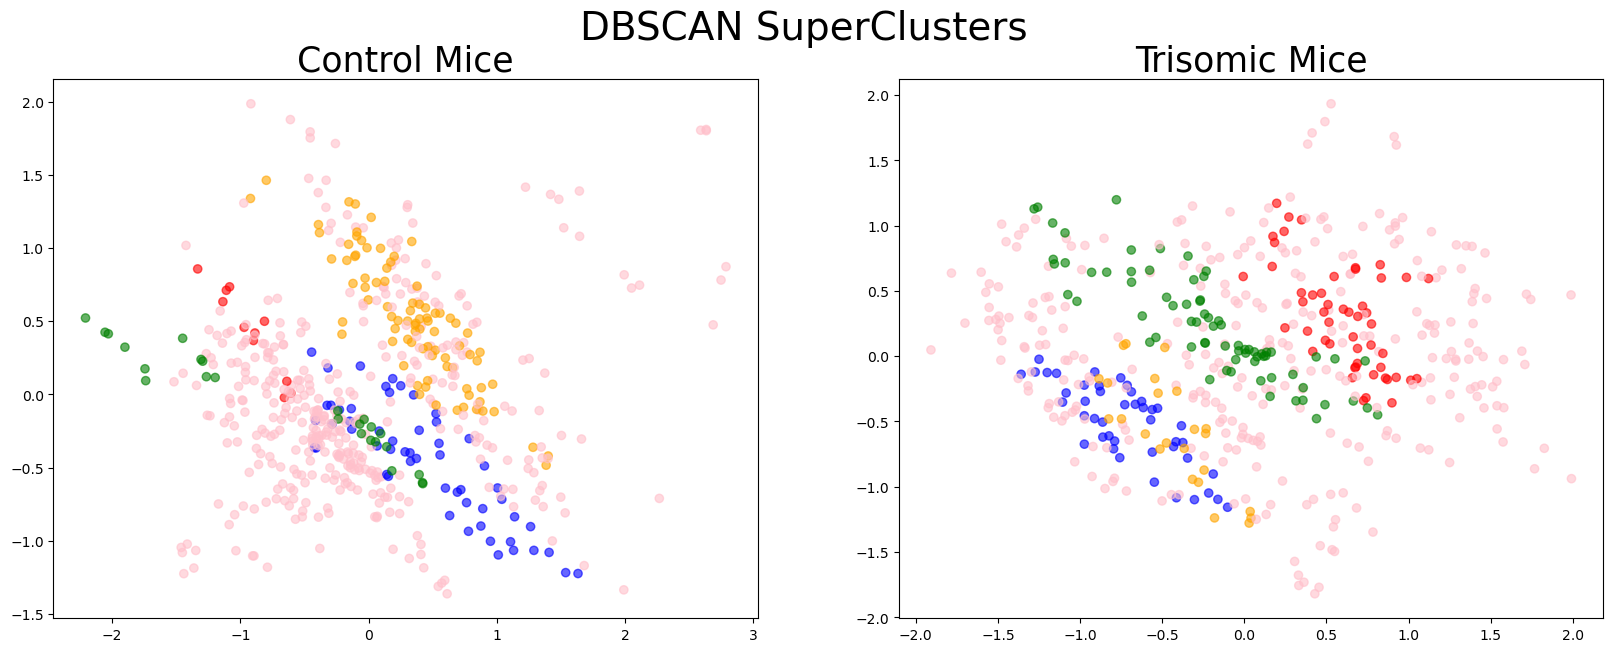

In [372]:
plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
f.suptitle("DBSCAN SuperClusters", fontsize = 28)
ax1.set_title("Control Mice", {'fontsize':25})
ax2.set_title("Trisomic Mice", {'fontsize':25})

clusterColorsControl = {"Noise":"pink", "c-CS-m":"blue", "c-CS-s":"orange", "c-SC-m":"red", "c-SC-s":"green"}
clusterColorsTrisomic = {"Noise":"pink", "t-CS-m":"blue", "t-CS-s":"orange", "t-SC-m":"red", "t-SC-s":"green"}

ax1.scatter(isoControl[:,0], isoControl[:,1], c= clusteredControls["DBSuper"].map(clusterColorsControl), alpha = 0.6)
ax2.scatter(isoTrisomic[:,0], isoTrisomic[:,1], c= clusteredTrisomics["DBSuper"].map(clusterColorsTrisomic), alpha = 0.6)


### Hypothesis Testing
Extract rows where cluster member matches cluster majority class, for each cluster. Convert to numpy arrays for use in the Wilcoxon rank-sums test.

In [380]:
cCSm = clusteredControls.loc[clusteredControls.Class == clusteredControls.DBSuper, :].loc[clusteredControls.DBSuper == "c-CS-m"].iloc[:,3:80].values
cCSs = clusteredControls.loc[clusteredControls.Class == clusteredControls.DBSuper, :].loc[clusteredControls.DBSuper == "c-CS-s"].iloc[:,3:80].values
cSCm = clusteredControls.loc[clusteredControls.Class == clusteredControls.DBSuper, :].loc[clusteredControls.DBSuper == "c-SC-m"].iloc[:,3:80].values
cSCs = clusteredControls.loc[clusteredControls.Class == clusteredControls.DBSuper, :].loc[clusteredControls.DBSuper == "c-SC-s"].iloc[:,3:80].values
tCSm = clusteredTrisomics.loc[clusteredTrisomics.Class == clusteredTrisomics.DBSuper, :].loc[clusteredTrisomics.DBSuper == "t-CS-m"].iloc[:,3:80].values
tCSs = clusteredTrisomics.loc[clusteredTrisomics.Class == clusteredTrisomics.DBSuper, :].loc[clusteredTrisomics.DBSuper == "t-CS-s"].iloc[:,3:80].values
tSCm = clusteredTrisomics.loc[clusteredTrisomics.Class == clusteredTrisomics.DBSuper, :].loc[clusteredTrisomics.DBSuper == "t-SC-m"].iloc[:,3:80].values
tSCs = clusteredTrisomics.loc[clusteredTrisomics.Class == clusteredTrisomics.DBSuper, :].loc[clusteredTrisomics.DBSuper == "t-SC-s"].iloc[:,3:80].values

For each of the groups in the following table, we will compare protein expression levels for all 77 proteins using the Wilcoxon rank-sums test. These pairs are the same as the pairs tested by the original authors. Since we clustered controls separately from trisomic mice, we will be able to assess the impact of context-schock-conditioning and memantine treatment in both subsets, but we will not be able to compare controls with trisomic mice. We will identify proteins whose expression levels are significantly different between the two pairs of classes.

| Compared Groups | Biological Interpretation | Number of Discriminant Proteins (DBSCAN) | Number of Discriminant Proteins (SOM) |
| --- | --- | --- | --- |
| c-CS-s vs c-SC-s | Effects of CFC training in saline treated controls | 55 | 31 |
| c-CS-m vs c-SC-m | Effects of CFC training in memantine treated controls | 68 | 23 |
| c-SC-m vs c-SC-s | Baseline effects of memantine in controls | 54 | 13 |
| c-CS-m vs c-CS-s | Effects of memantine on learning in controls | 70 | 12 |
| t-CS-s vs t-SC-s | Effects of CFC training in saline treated trisomics | 56 | 10 |
| t-CS-m vs t-SC-m | Effects of CFC training in memantine treated trisomics | 59 | 36 |
| t-SC-m vs t-SC-s | Baseline effects of memantine in trisomics | 66 | 12 |
| t-CS-m vs t-CS-s | Effects of memantine on learning in trisomics | 45 | 9 |

In [402]:
testPairs = [(cCSs, cSCs), (cCSm, cSCm), (cSCm, cSCs), (cCSm, cCSs), 
             (tCSs, tSCs), (tCSm, tSCm), (tSCm, tSCs), (tCSm, tCSs)]

pValueMatrix = np.zeros(shape=(8, 77))
counter = 0
numDiscProtsDBSCAN = []
for i in testPairs:
    ps = []
    for j in range(77):
        ps.append(ranksums(i[0][:,j], i[1][:,j]).pvalue)
    pValueMatrix[counter] = ps
    numDiscProtsDBSCAN.append(sum(pValueMatrix[counter] < 0.05))
    counter += 1

According to the original authors' analysis, proteins with p-value < 0.05 were considered to be significantly different between the two classes, and these proteins were taken to have class-discriminating properties.

Using their approach, the authors were able to really narrow down on the most important proteins, but my approach seems to mark most proteins as important.

Therefore, in order to compare my results with the authors, I will create lists of my most significantly different proteins for each pair (the length of the list will be equal to the length of the author's list of significant proteins). I will compare the identities of the proteins between these lists, to check if at least the protein identities that I'm recovering match the original results.

In [435]:
numDiscProtsSOM = [31, 23, 13, 12, 10, 36, 12, 9]
protsDBSCAN = []
for i in range(8):
    indsPreliminary = np.argsort(pValueMatrix[i,:])[:numDiscProtsSOM[i]]
    inds = np.add(indsPreliminary, 3).tolist()
    protsDBSCAN.append(clusteredControls.columns[inds].tolist())

My proteins don't match theirs exactly. Let's take an intersection of my whetted down lists and their lists. 

| Compared Groups | Number of Discriminant Proteins (DBSCAN) | Number of Discriminant Proteins (SOM) | Number of Proteins in Common with reduced list | Number of Proteins in Common with Complete LIst |
| --- | --- | --- | --- | --- |
| c-CS-s vs c-SC-s | 55 | 31 | 20 | 26 |
| c-CS-m vs c-SC-m | 68 | 23 | 13 | 20 |
| c-SC-m vs c-SC-s | 54 | 13 | 1 | 9 |
| c-CS-m vs c-CS-s | 70 | 12 | 1 | 11 |
| t-CS-s vs t-SC-s | 56 | 10 | 4 | 9 |
| t-CS-m vs t-SC-m | 59 | 36 | 28 | 35 |
| t-SC-m vs t-SC-s | 66 | 12 | 7 | 11 |
| t-CS-m vs t-CS-s | 45 | 9 | 3 | 7 |

In [446]:
protsSOM = [["APP_N", "ARC_N", "BAD_N", "BDNF_N", "BRAF_N", "CaNA_N", "CDK5_N", "DYRK1A_N", "EGR1_N", "ERBB4_N", "ERK_N", "GFAP_N", "GSK3B_N", "H3MeK4_N", "IL1B_N", "ITSN1_N", "nNOS_N", "P38_N", "pERK_N", "pGSK3B_N", "PKCA_N", "pNUMB_N", "pPKCAB_N", "pRSK_N", "pS6_N", "PSD95_N", "S6_N", "SHH_N", "SNCA_N", "SOD1_N", "Ubiquitin"],
["ADARB1_N", "APP_N", "BDNF_N", "BRAF_N", "CaNA_N", "CDK5_N", "DYRK1A_N", "EGR1_N", "ERK_N", "GFAP_N", "GSK3B_N", "ITSN1_N", "NR2A_N", "P3525_N", "P38_N", "pCAMKII_N", "pERK_N", "pGSK3B_N", "pNUMB_N", "S6_N", "SOD1_N", "TRKA_N", "Ubiquitin"],
["AKT_N", "ARC_N", "BCL2_N", "ELK_N", "H3AcK18_N", "NR1_N", "pCAMKII_N", "pNR1_N", "pNUMB_N", "pPKCG_N", "pS6_N", "SOD1_N", "Ubiquitin"],
["ARC_N", "BAD_N", "EGR1_N", "ERBB4_N", "H3MeK4_N", "IL1B_N", "nNOS_N", "PKCA_N", "pPKCAB_N", "pS6_N", "SHH_N", "Ubiquitin"],
["BRAF_N", "DYRK1A_N", "GluR4_N", "ITSN1_N", "MTOR_N", "NR2B_N", "P38_N", "pERK_N", "pP70S6_N", "SOD1"],
["AKT_N", "AMPKA_N", "ARC_N", "BRAF_N", "CAMKII_N", "CaNA_N", "DSCR1_N", "DYRK1A_N", "EGR1_N", "ERBB4_N", "GSK3B_N", "H3AcK18_N", "H3MeK4_N", "ITSN1_N", "MTOR_N", "NR2B_N", "P38_N", "pAKT_N", "pBRAF_N", "pCREB_N", "pERK_N", "pGSK3B_N", "pGSK3B_Tyr216_N", "pJNK_N", "pMEK_N", "pMTOR_N", "pNR2A_N", "pNR2B_N", "pS6_N", "RAPTOR_N", "RSK_N", "S6_N", "SNCA_N", "SOD1_N", "TIAM1_N", "Ubiquitin"],
["ARC_N", "BAD_N", "ERBB4_N", "P3525_N", "pMTOR_N", "pNR2A_N", "pP70S6_N", "pPKCAB_N", "pPKCG_N", "pS6_N", "S6_N", "SNCA"],
["BRAF_N", "CDK5_N", "DYRK1A_N", "GFAP_N", "GluR3_N", "P3525_N", "pERK_N", "RRP1_N", "Ubiquitin"]]

In [449]:
intersxns = []
commonNumber = []
for i in range(8):
    comm = list(set(protsDBSCAN[i]) & set(protsSOM[i]))
    intersxns.append(comm)
    commonNumber.append(len(comm))
    
commonNumber

[20, 13, 1, 1, 4, 28, 7, 3]

In [463]:
intersxns = []
commonNumber = []
for i in range(8):
    fullset = set(clusteredControls.iloc[:,3:80].columns[pValueMatrix[i] < 0.05])
    comm = list(fullset & set(protsSOM[i]))
    intersxns.append(comm)
    commonNumber.append(len(comm))   
    
commonNumber

[26, 20, 9, 11, 9, 35, 11, 7]